# EMI Project — Cleaned Notebook (Updated)
**Changes added:**
- Project header and mapping to the Word spec (Project Title 2.docx).
- Reproducible data load cell with relative paths + sanity checks.
- Preprocessing pipeline (sklearn ColumnTransformer + Pipeline) skeleton.
- MLflow training & logging wrapper functions.
- Minimal Streamlit `predict` page snippet.
- SQLite CRUD demo snippet.
- Final acceptance checklist (tick before submission).

*I added these helper cells at the top so you'll find the essential reproducibility + deployment code immediately. Scroll down to see the original notebook content preserved after these new cells.*

**Referenced spec file:** `/mnt/data/Project Title 2.docx` (ensure it is the correct project brief).

In [ ]:
# Data load & sanity checks (edit DATA_DIR if needed)
from pathlib import Path
import pandas as pd
DATA_DIR = Path('./data')
DATA_PATH = DATA_DIR / 'EMI_dataset.csv'

print('Expected data path:', DATA_PATH)
if not DATA_PATH.exists():
    print('WARNING: EMI_dataset.csv not found at', DATA_PATH)
    print('Please place the dataset in the ./data folder or update DATA_PATH accordingly.')
else:
    df = pd.read_csv(DATA_PATH)
    print('Shape:', df.shape)
    display(df.head())
    missing = df.isnull().sum().sort_values(ascending=False)
    missing_pct = (missing / len(df) * 100).round(2)
    display(pd.DataFrame({'missing_count': missing, 'missing_pct': missing_pct}).head(20))

# For heavy datasets, create a sample for exploration (uncomment to use)
# sample_df = df.sample(n=50000, random_state=42)
# display(sample_df.head())


In [ ]:
# Preprocessing pipeline skeleton (sklearn)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# EDIT the feature lists below to match your dataset column names
numeric_feats = ['age','monthly_salary','years_of_employment','monthly_rent','family_size','dependents','school_fees','college_fees','travel_expenses','groceries_utilities','other_monthly_expenses','current_emi_amount','credit_score','bank_balance','emergency_fund','requested_amount','requested_tenure']
cat_feats = ['gender','marital_status','education','employment_type','company_type','house_type','emi_scenario']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_feats),
    ('cat', cat_pipeline, cat_feats),
], remainder='drop')

print('Preprocessing pipeline created. Edit feature lists to match your dataset columns.')


In [ ]:
# MLflow training & logging helper (lightweight wrapper)
import mlflow, mlflow.sklearn
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score

RANDOM_STATE = 42

def eval_classification(y_true, y_pred, y_proba=None):
    return {
        'accuracy': float(accuracy_score(y_true, y_pred)),
        'precision': float(precision_score(y_true, y_pred, average='weighted', zero_division=0)),
        'recall': float(recall_score(y_true, y_pred, average='weighted', zero_division=0)),
        'f1': float(f1_score(y_true, y_pred, average='weighted', zero_division=0)),
        'roc_auc': float(roc_auc_score(y_true, y_proba, multi_class='ovr')) if (y_proba is not None and y_proba.ndim>1) else None
    }

def eval_regression(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    # MAPE safe
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true==0, np.nan, y_true))) * 100
    return {'rmse': float(rmse), 'mae': float(mae), 'r2': float(r2), 'mape': float(mape)}

def train_and_log(model, X_train, y_train, X_val, y_val, problem='classification', experiment_name='emi_project', run_name=None, params=None):
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run(run_name=run_name):
        if params:
            mlflow.log_params(params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_proba = None
        if problem=='classification' and hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_val)
        if problem=='classification':
            metrics = eval_classification(y_val, y_pred, y_proba)
        else:
            metrics = eval_regression(y_val, y_pred)
        mlflow.log_metrics({k:v for k,v in metrics.items() if v is not None})
        mlflow.sklearn.log_model(model, artifact_path='model')
        return metrics

print('MLflow helper functions defined. Configure MLFLOW_TRACKING_URI as needed.')


In [ ]:
# Minimal Streamlit predict page snippet (save as app/streamlit_app.py or paste into your Streamlit cell)
# Note: adjust MODEL_PATH and PIPE_PATH to point to your exported joblib files

# import streamlit as st
# import joblib
# import pandas as pd
# from pathlib import Path
#
# MODEL_PATH = Path('./models/exported_models/classifier.pkl')
# PIPE_PATH = Path('./models/exported_models/preprocessor.pkl')
#
# @st.cache_resource
# def load_artifacts():
#     model = joblib.load(MODEL_PATH)
#     preproc = joblib.load(PIPE_PATH)
#     return model, preproc
#
# st.title('EMIPredict — EMI Eligibility & Max EMI Prediction')
# model, preproc = load_artifacts()
#
# with st.form('input_form'):
#     age = st.number_input('Age', min_value=18, max_value=100, value=30)
#     monthly_salary = st.number_input('Monthly Salary', min_value=1000)
#     requested_amount = st.number_input('Requested Amount', min_value=1000)
#     submitted = st.form_submit_button('Predict')
#     if submitted:
#         input_df = pd.DataFrame([{'age': age, 'monthly_salary': monthly_salary, 'requested_amount': requested_amount}])
#         X = preproc.transform(input_df)
#         class_pred = model.predict(X)
#         proba = model.predict_proba(X) if hasattr(model, 'predict_proba') else None
#         st.write('Predicted EMI eligibility:', class_pred[0])
#         if proba is not None:
#             st.write('Probabilities:', proba[0])

print('Streamlit snippet added as a commented cell. Copy to app/streamlit_app.py for deployment.')

In [ ]:
# SQLite CRUD demo (run in notebook or use in Streamlit admin page)
import sqlite3, pandas as pd
conn = sqlite3.connect('data/emi_db.sqlite', check_same_thread=False)
cursor = conn.cursor()

cursor.execute('''
CREATE TABLE IF NOT EXISTS applicants (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    age INTEGER,
    gender TEXT,
    monthly_salary REAL,
    emi_scenario TEXT,
    emi_eligibility TEXT,
    max_monthly_emi REAL
)
''')
conn.commit()

print('SQLite DB initialized at data/emi_db.sqlite')

def insert_applicant(record: dict):
    cols = ','.join(record.keys())
    vals = tuple(record.values())
    q = f"INSERT INTO applicants ({cols}) VALUES ({','.join(['?']*len(vals))})"
    cursor.execute(q, vals)
    conn.commit()
    return cursor.lastrowid

print('insert_applicant function available. Example: insert_applicant({"age":30, "gender":"M", "monthly_salary":50000})')

## Final Acceptance Checklist — tick before submission
- [ ] Top cell: project title + mapping to Word spec (`/mnt/data/Project Title 2.docx`).
- [ ] Data load with assertions and sample fallback.
- [ ] Preprocessing pipeline implemented and saved.
- [ ] Derived features (debt_to_income, expense_to_income, affordability ratios) created and used.
- [ ] EDA with required plots & 1-paragraph business insight.
- [ ] At least 3 classification + 3 regression models trained and compared.
- [ ] All required metrics computed and logged to MLflow (or documented if using local mlruns).
- [ ] Best models saved to `models/exported_models/`.
- [ ] Streamlit app snippet included and uses saved pipeline & model.
- [ ] CRUD demo (sqlite or csv) present.
- [ ] `requirements.txt` and README with run instructions included.
- [ ] Notebook runs top→bottom without errors (parameterize heavy training cells if needed).

If you want, I can now:  
- apply these snippets directly into appropriate notebook locations beyond the top (e.g., replace broken cells), OR
- run a quick static check for common errors (missing imports, bad paths) inside the notebook.  

Tell me which next step you'd like, or download the updated notebook below and inspect it locally.

In [1]:
import os,joblib,traceback

# Define the helper function directly in the global scope
def ensure_classification_bundle(auto_retrain=True, training_code_str=""):
    """
    Ensures classification model + feature_names files exist.
    If missing, automatically retra`ins using the provided training_code_str.
    """
    bundle_file = "best_bundle_classification.pkl"
    feat_file = "feature_names_classification.pkl"

    if os.path.exists(bundle_file) and os.path.exists(feat_file):
        print("✔ Classification bundle and feature files found.")
        return True

    if not auto_retrain:
        raise FileNotFoundError(f"❌ Required files missing: {bundle_file} or {feat_file}")

    if not training_code_str:
        raise RuntimeError("❌ `training_code_str` argument is empty. Provide the actual training script as a string to enable auto-retraining.")

    print("⚠ Missing model files — starting AUTO-RETRAIN...")

    # Execute the training code
    try:
        exec(training_code_str, globals(), locals())
    except Exception as e:
        tb = traceback.format_exc()
        raise RuntimeError(f"❌ Auto-retraining failed:\n{tb}")

    # Check again
    if not (os.path.exists(bundle_file) and os.path.exists(feat_file)):
        raise RuntimeError(
            "❌ Training completed but files were not saved.\n"
            "Make sure your training code includes:\n"
            "joblib.dump(bundle, 'best_bundle_classification.pkl')\n"
            "joblib.dump(feature_names_classification, 'feature_names_classification.pkl')"
        )

    print("✔ Auto-retrain completed successfully!")
    return True

# Define the TRAINING_CODE variable separately. This string should contain the *actual*
# Python code that performs the model training and saves the bundle and feature names.
# For now, it's set to a placeholder, as the actual training logic is performed directly
# in other cells. The user would need to consolidate their training logic here if
# they want auto-retraining to function.
TRAINING_CODE = """
# Assuming necessary libraries like sklearn.ensemble, xgboost, joblib, pandas are imported globally
# Assuming X_smote, Y_smote, Xtrain, cat, con, target_col are available in the global scope

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib
import pandas as pd # Needed for Xtrain.columns access if not already imported in the exec scope

# Train the XGBClassifier model, which was identified as 'best_model' in a previous cell
model_classifier = XGBClassifier()
model_classifier.fit(X_smote, Y_smote) # Use X_smote and Y_smote as per current training flow

# Define feature_names_classification from Xtrain.columns
feature_names_classification = list(Xtrain.columns)

# Create the bundle
bundle = {
    "model": model_classifier,
    "preprocessor": None, # Based on the notebook, preprocessor is not used for classification in the bundle
    "feature_names": feature_names_classification, # Use the defined feature_names_classification
    "numeric_features": con,
    "categorical_features": cat,
    "target_col": target_col,
    "mode": "classification"
}

# Save the bundle and feature names
joblib.dump(bundle, "best_bundle_classification.pkl")
joblib.dump(feature_names_classification, "feature_names_classification.pkl")
"""

In [2]:
# Added: Standard imports and helper to normalize column names
import pandas as pd
import numpy as np
def normalize_cols(df):
    """Normalize DataFrame column names: strip, lower, replace spaces with underscore."""
    df = df.copy()
    df.columns = [str(c).strip().lower().replace(' ', '_') for c in df.columns]
    return df

print('Helper normalize_cols and common imports are available.')

Helper normalize_cols and common imports are available.


In [3]:
# NOTE: I didn't find OneHotEncoder usage in the notebook; if you use it, ensure:
# OneHotEncoder(handle_unknown='ignore', sparse=False)
print('Reminder: if using OneHotEncoder, use handle_unknown="ignore" to avoid unseen-category errors')


Reminder: if using OneHotEncoder, use handle_unknown="ignore" to avoid unseen-category errors


In [4]:
%pip install streamlit

In [5]:
%pip install mlflow

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from xgboost import XGBClassifier,XGBRegressor
from sklearn.metrics import accuracy_score,f1_score,recall_score,confusion_matrix,r2_score,mean_squared_error,classification_report
import mlflow
import mlflow.sklearn
import streamlit as st
from scipy import sparse
import joblib
import os,math
from collections import Counter

In [8]:
EXPERIMENT_NAME = "EMI Prediction"
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='file:///content/mlruns/897336156112150216', creation_time=1764346034007, experiment_id='897336156112150216', last_update_time=1764346034007, lifecycle_stage='active', name='EMI Prediction', tags={}>

In [9]:
 # 1. Load Data
df = pd.read_csv("emi_prediction_dataset.csv", encoding="utf-8")

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404800 entries, 0 to 404799
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   age                     404800 non-null  object 
 1   gender                  404800 non-null  object 
 2   marital_status          404800 non-null  object 
 3   education               402396 non-null  object 
 4   monthly_salary          404800 non-null  object 
 5   employment_type         404800 non-null  object 
 6   years_of_employment     404800 non-null  float64
 7   company_type            404800 non-null  object 
 8   house_type              404800 non-null  object 
 9   monthly_rent            402374 non-null  float64
 10  family_size             404800 non-null  int64  
 11  dependents              404800 non-null  int64  
 12  school_fees             404800 non-null  float64
 13  college_fees            404800 non-null  float64
 14  travel_expenses     

In [11]:
df.isnull().sum()

,0
age,0
gender,0
marital_status,0
education,2404
monthly_salary,0
employment_type,0
years_of_employment,0
company_type,0
house_type,0
monthly_rent,2426


In [12]:
# Null Value Treatment
for i in df.columns:
    if df[i].dtypes=='object':
      df[i]=df[i].fillna(df[i].mode()[0])
    else:
      df[i]=df[i].fillna(df[i].mean())

In [13]:
df.isnull().sum()

,0
age,0
gender,0
marital_status,0
education,0
monthly_salary,0
employment_type,0
years_of_employment,0
company_type,0
house_type,0
monthly_rent,0


In [14]:
#Classification
target_col = 'emi_eligibility'

In [15]:
# Map target to numerical (Eligible -> 1, Not_Eligible -> 0)
df[target_col] = df[target_col].map({'Eligible': 1, 'Not_Eligible': 0})
df = df.dropna(subset=[target_col])
df[target_col] = df[target_col].astype('int')

In [16]:
# Print value counts to be sure both classes exist
print(df[target_col].value_counts())

emi_eligibility
0    312868
1     74444
Name: count, dtype: int64


In [17]:
# Remove columns that shouldn't be features
drop_cols = ['emi_eligibility']
X = df.drop(drop_cols, axis=1)
y = df[target_col]

In [18]:
if "monthly_salary" in df.columns and "max_monthly_emi" in df.columns:
    # Convert 'monthly_salary' to numeric, handling non-numeric values by coercing to NaN
    df["monthly_salary"] = pd.to_numeric(df["monthly_salary"], errors='coerce')
    # Fill any NaNs created by coercion or existing ones with the mean of the column
    df["monthly_salary"] = df["monthly_salary"].fillna(df["monthly_salary"].mean())
    # Now perform the division with numeric types
    df["emi_to_income_ratio"] = df["max_monthly_emi"] / df["monthly_salary"].replace(0, np.nan)


In [19]:
# Separate cat and con from X
cat=[]
con=[]
for i in X.columns:
  if X[i].dtypes==object:
    cat.append(i)
  else:
    con.append(i)

In [20]:
Xcat=X[cat]
Xcon=X[con]

In [21]:
# Preprocessing
from sklearn.preprocessing import LabelEncoder,StandardScaler

In [22]:
# Feature Encoding
le=LabelEncoder()
for i in Xcat.columns:
    # Convert columns with mixed data types to numeric
    if i in ['age', 'monthly_salary', 'bank_balance']:
        Xcat[i] = pd.to_numeric(Xcat[i], errors='coerce')
        # Fill NaN values after conversion with the mean
        Xcat[i] = Xcat[i].fillna(Xcat[i].mean())
    else:
      Xcat[i]=le.fit_transform(Xcat[i])

In [23]:
# Feature Scaling
ss= StandardScaler()
Xcon=pd.DataFrame(ss.fit_transform(Xcon),columns=con)

In [24]:
X=Xcon.join(Xcat)
X

,years_of_employment,monthly_rent,family_size,dependents,school_fees,college_fees,travel_expenses,groceries_utilities,other_monthly_expenses,current_emi_amount,...,gender,marital_status,education,monthly_salary,employment_type,company_type,house_type,existing_loans,bank_balance,emi_scenario
0,-0.733857,1.638815,0.052202,0.052202,-0.922196,-0.563848,0.460075,0.975241,1.365147,2.712162,...,2.0,0.0,3.0,82600.0,1.0,2.0,2.0,1.0,303200.0,3.0
1,0.270665,-0.683361,-0.879692,-0.879692,0.082658,-0.563848,-1.255263,-1.048000,-0.794648,-0.072328,...,2.0,0.0,0.0,21500.0,1.0,1.0,0.0,1.0,92500.0,0.0
2,0.073054,-0.683361,0.984096,0.984096,-0.922196,-0.563848,1.347318,0.960891,-0.238000,-0.654798,...,5.0,0.0,3.0,86100.0,1.0,4.0,1.0,0.0,672100.0,1.0
3,-0.519779,-0.683361,1.915990,1.915990,1.323948,-0.563848,0.164327,-0.115300,0.185053,-0.654798,...,2.0,0.0,1.0,66800.0,1.0,2.0,1.0,0.0,440900.0,4.0
4,-0.322168,-0.683361,0.984096,0.984096,0.929887,2.317162,-0.604618,0.501716,0.229585,-0.654798,...,2.0,0.0,3.0,57300.0,1.0,2.0,0.0,0.0,97300.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387307,3.399505,-0.102817,0.052202,0.052202,0.575233,1.573239,-1.018665,-1.277587,-1.262233,0.027118,...,5.0,0.0,1.0,50100.0,1.0,2.0,0.0,0.0,399600.0,4.0
387308,-0.058687,0.524171,0.984096,0.984096,-0.370512,0.382963,-1.018665,-1.119746,-0.215734,-0.654798,...,2.0,0.0,2.0,32800.0,1.0,4.0,1.0,1.0,158900.0,3.0
387309,-0.569182,-0.683361,1.915990,1.915990,1.836226,-0.563848,-0.900366,0.128636,0.340914,-0.654798,...,5.0,0.0,0.0,37000.0,1.0,2.0,2.0,1.0,123000.0,1.0
387310,-0.388038,-0.683361,0.984096,0.984096,-0.922196,-0.563848,0.400925,-0.545777,0.029191,-0.654798,...,5.0,0.0,0.0,35000.0,1.0,0.0,0.0,0.0,271600.0,2.0


In [25]:
# Label Encode Y since  it is a categorical output with related categoric outputs.
y=le.fit_transform(y)
y=pd.DataFrame(y,columns=['emi_eligibility'])
y

,emi_eligibility
0,0
1,0
2,1
3,1
4,0
...,...
387307,0
387308,0
387309,0
387310,1


In [26]:
# Remove outliers and reset the index.
out=[]
for i in Xcon.columns:
  o1=Xcon[(Xcon[i]<-3)|(Xcon[i]>3)].index
  out.extend(o1)
out=list(set(out))

In [27]:
print(out)

[131076, 6, 131078, 8, 262153, 9, 262154, 262158, 15, 131089, 262162, 131094, 262173, 33, 262179, 35, 131114, 262187, 262188, 46, 262191, 131119, 131118, 49, 262195, 52, 131124, 131125, 262207, 131136, 72, 262217, 131149, 131151, 131152, 131153, 262232, 92, 262236, 131164, 96, 98, 131172, 131174, 103, 262249, 131178, 262252, 116, 117, 131193, 131194, 131197, 262276, 131207, 135, 262289, 131228, 131232, 163, 262310, 131241, 131242, 174, 262324, 262328, 185, 131259, 131263, 131267, 262342, 131271, 200, 262345, 131275, 131278, 131290, 227, 228, 131304, 131305, 262376, 262379, 131310, 131312, 262385, 262386, 262388, 245, 246, 262392, 262394, 255, 261, 262405, 131335, 131337, 131339, 131345, 285, 286, 288, 289, 290, 131363, 131374, 262449, 262458, 131386, 262461, 131389, 131392, 262465, 323, 131396, 327, 329, 333, 334, 262485, 342, 262487, 131415, 341, 262498, 131428, 262503, 363, 131439, 368, 370, 262515, 372, 375, 262519, 379, 262527, 385, 262532, 262534, 394, 131471, 131473, 131475, 403,

In [28]:
X=X.drop(index=out,axis=0)
y=y.drop(index=out,axis=0)

In [29]:
X.shape

(342668, 26)

In [30]:
y.shape

(342668, 1)

In [31]:
# Perform train test split
from sklearn.model_selection import train_test_split
Xtrain,Xtest,Ytrain,Ytest=train_test_split(X,y,test_size=0.2,random_state=42)

In [32]:
#  Reduce biasedness of data using SMOTE
from imblearn.over_sampling import SMOTE

In [33]:
# Check for any remaining NaN values in X and y
print("NaNs in X before SMOTE:", X.isnull().sum().sum())
print("NaNs in y before SMOTE:", y.isnull().sum().sum())

# Drop rows with NaN values from both X and y
X_cleaned = X.dropna()
y_cleaned = y.loc[X_cleaned.index] # Ensure y is aligned with cleaned X

# Apply SMOTE to the cleaned data
X_smote, Y_smote = SMOTE().fit_resample(X_cleaned, y_cleaned)

NaNs in X before SMOTE: 163768
NaNs in y before SMOTE: 0


In [34]:
Y_smote.value_counts()

,count
emi_eligibility,
0,271249
1,271249


In [35]:
# Create graphs of various columns
from matplotlib.pyplot import plot,show
import seaborn as sns
import matplotlib.pyplot as plt

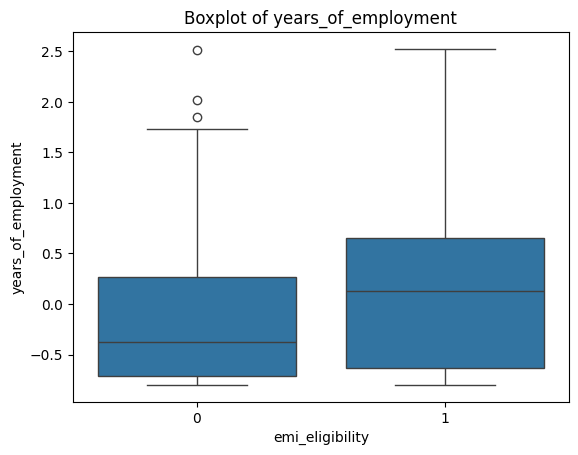

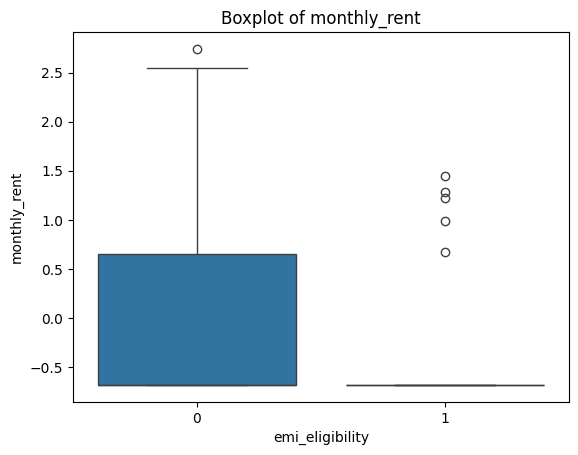

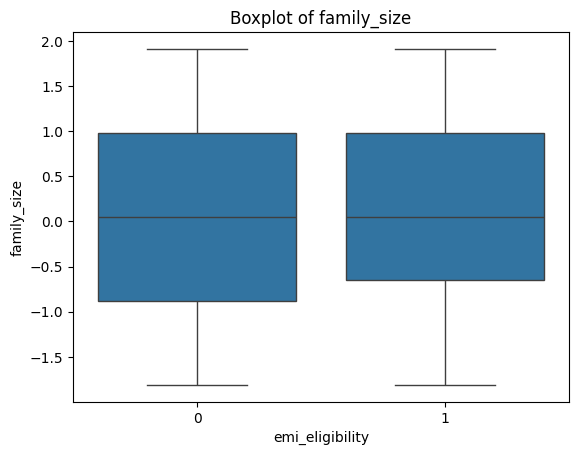

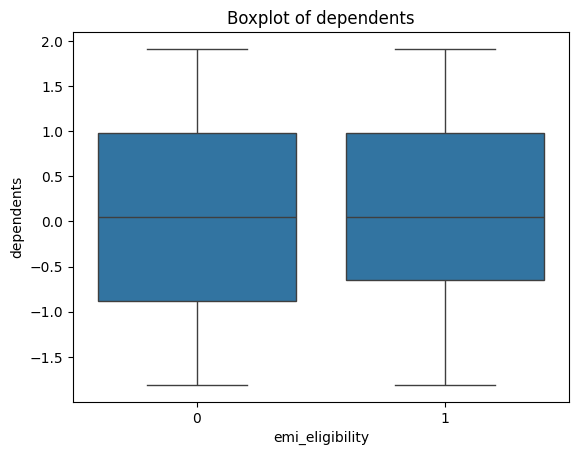

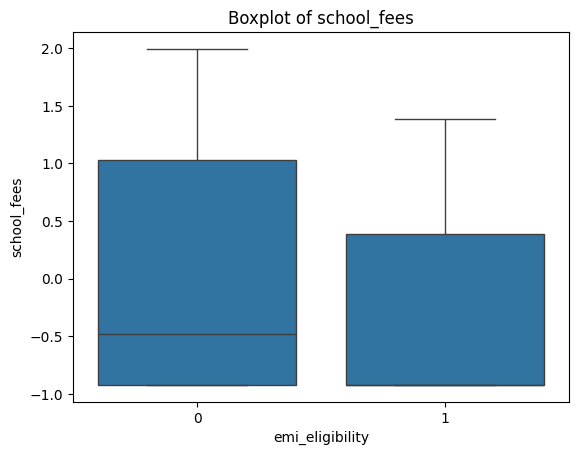

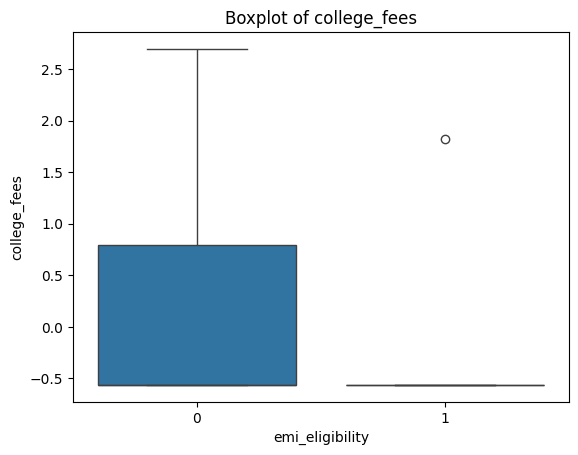

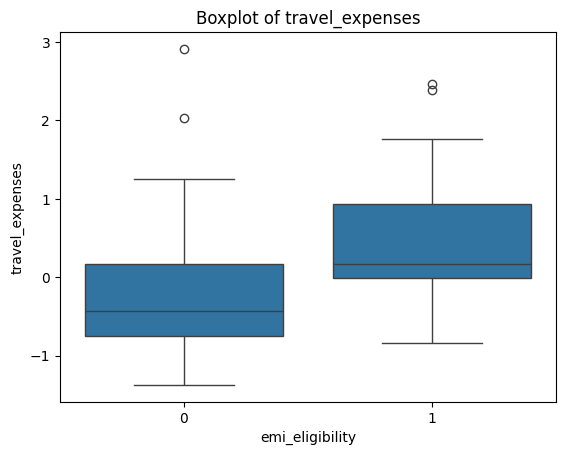

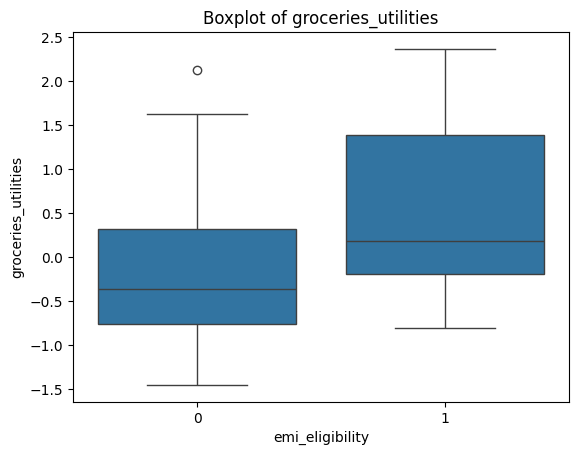

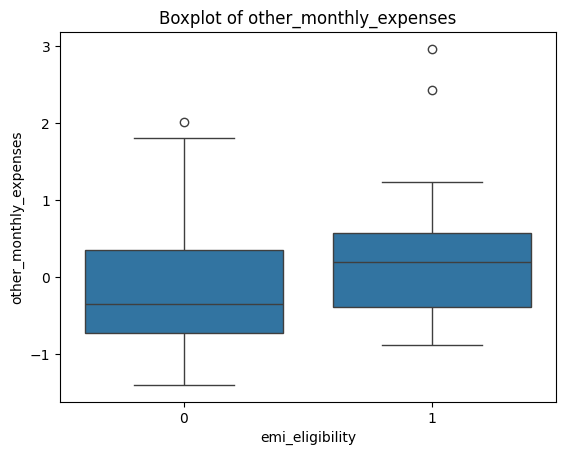

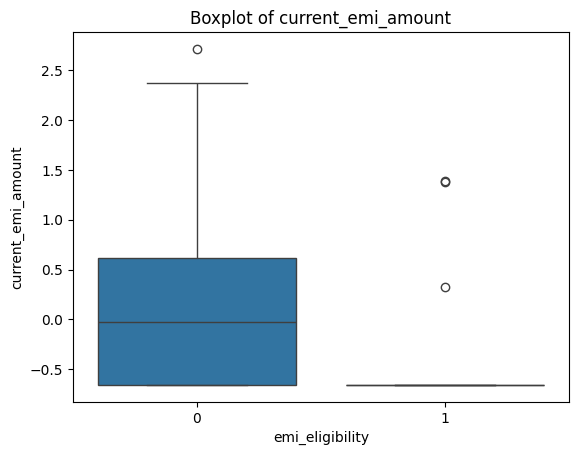

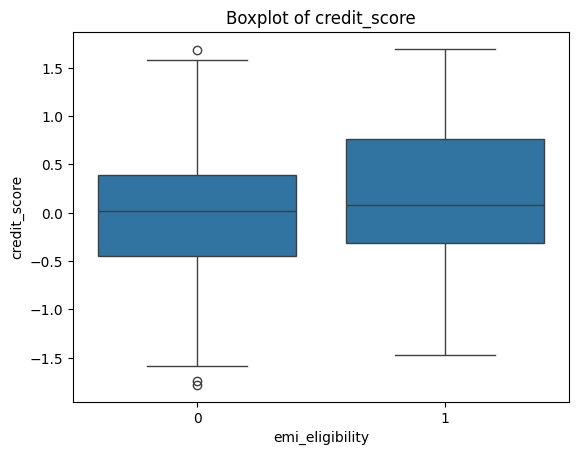

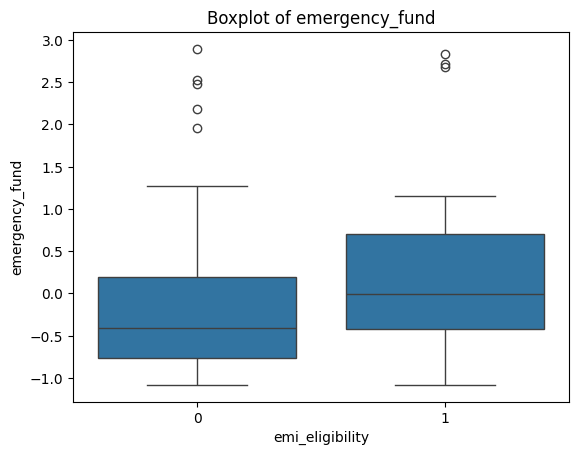

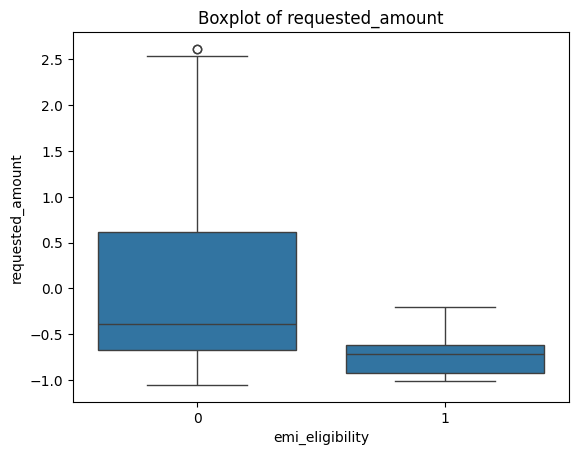

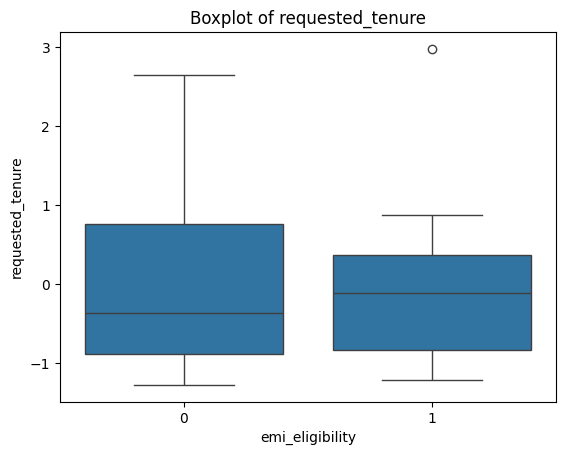

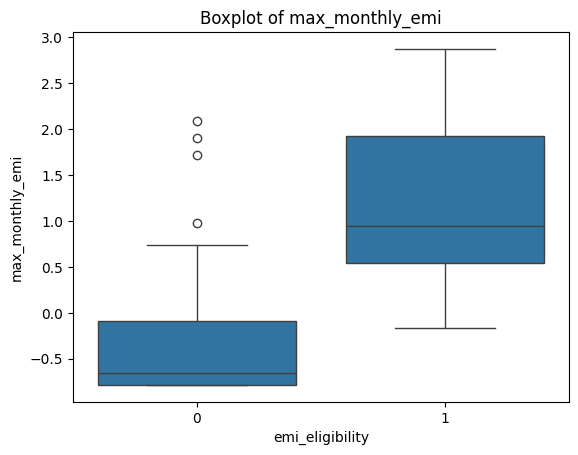

In [36]:
for i in con:
  sns.boxplot(x=Y_smote['emi_eligibility'],y=X_smote[i].head(100))
  plt.title(f'Boxplot of {i}')
  show()

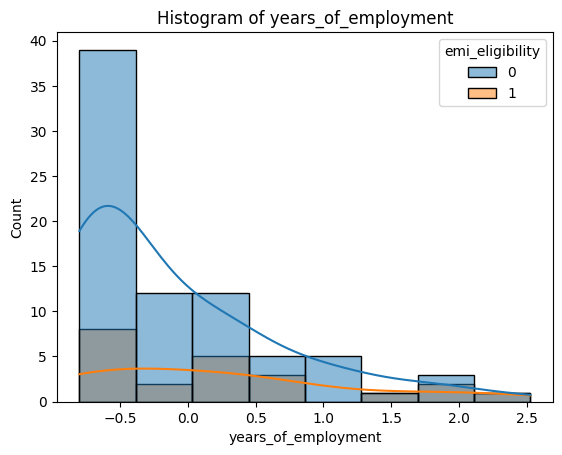

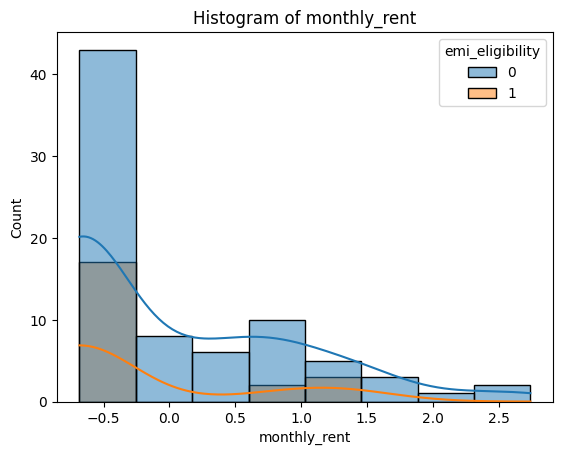

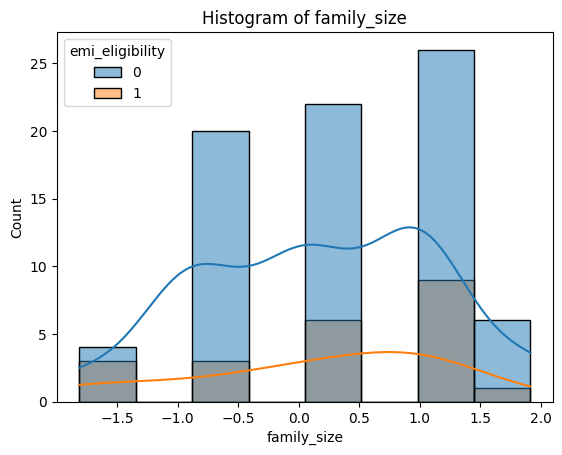

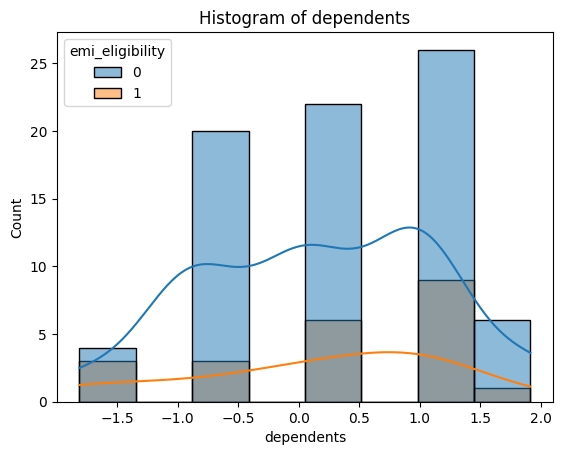

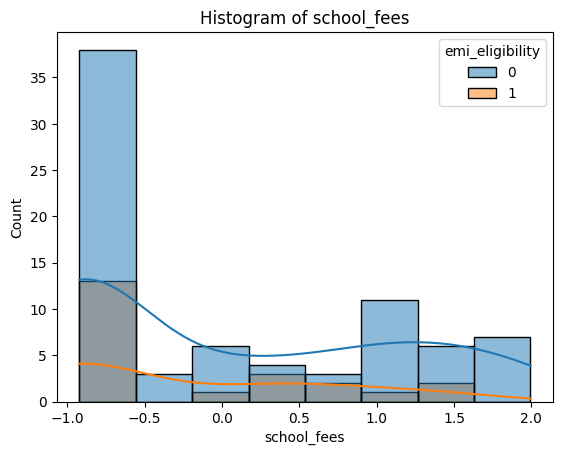

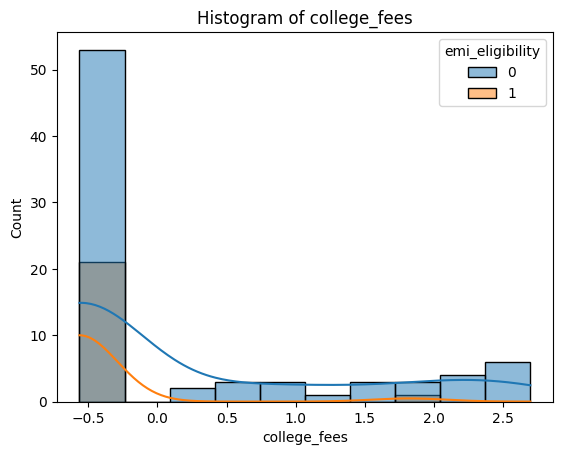

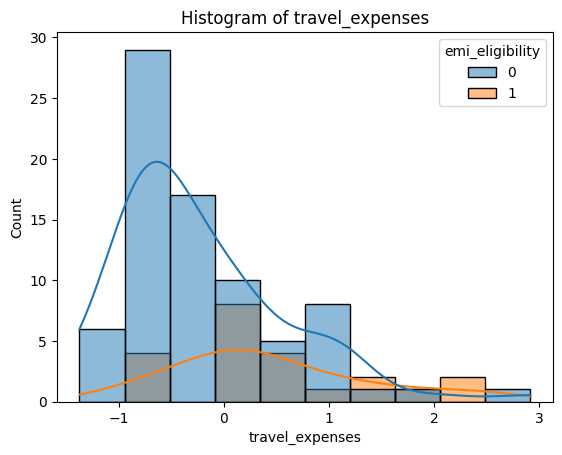

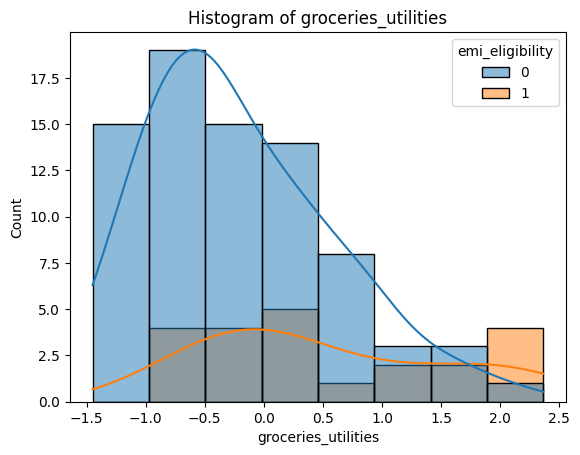

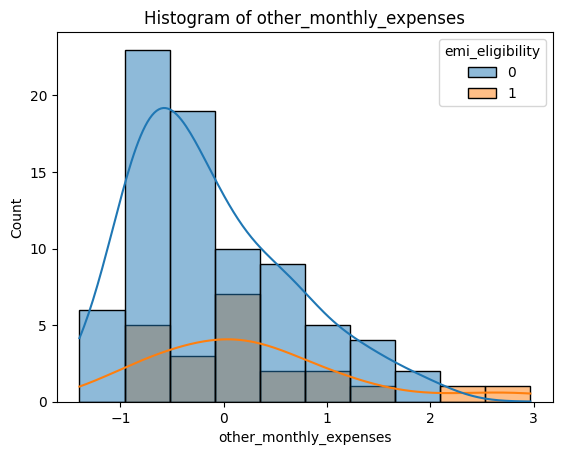

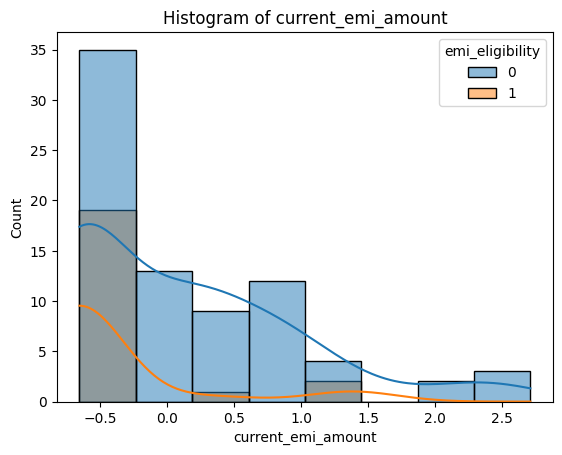

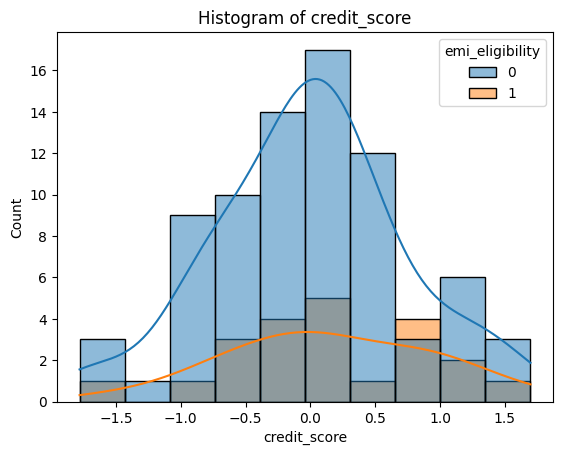

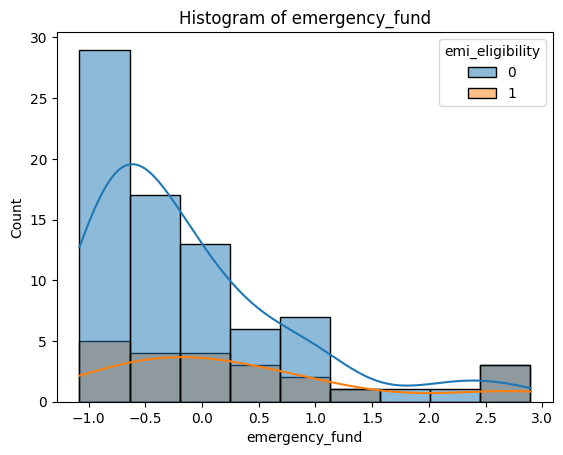

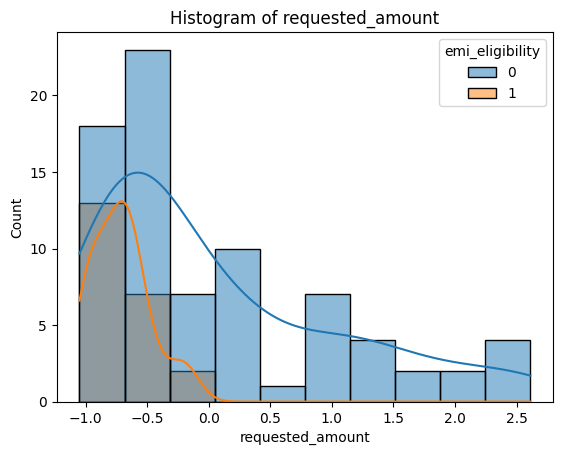

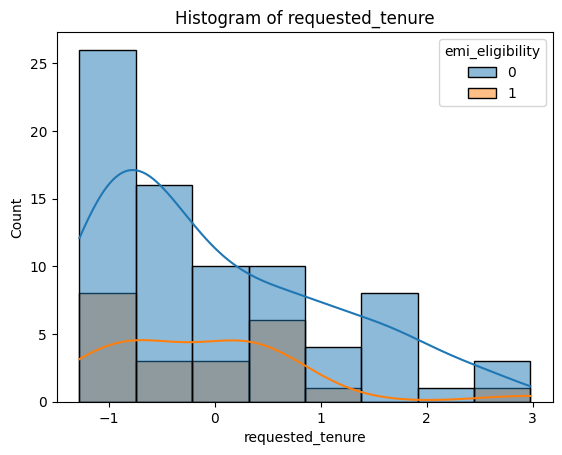

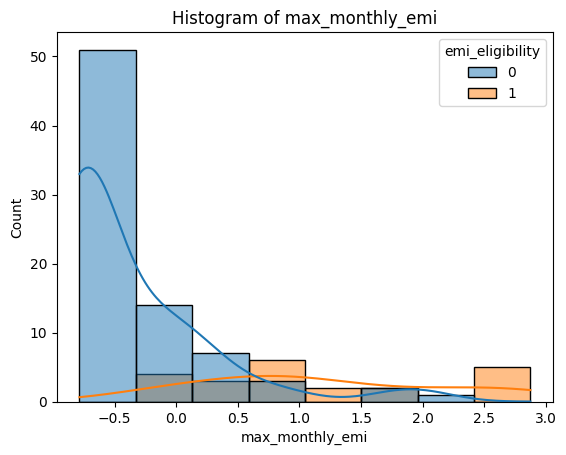

In [37]:
for i in con:
  sns.histplot(x=X_smote[i].head(100),hue=Y_smote['emi_eligibility'],kde=True)
  plt.title(f'Histogram of {i}')
  show()

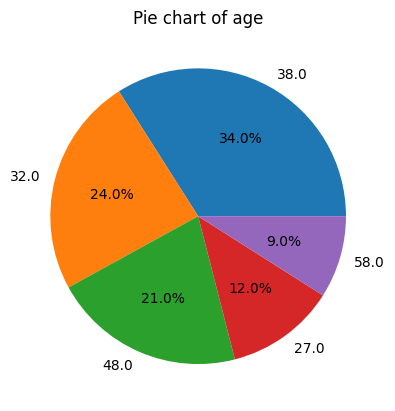

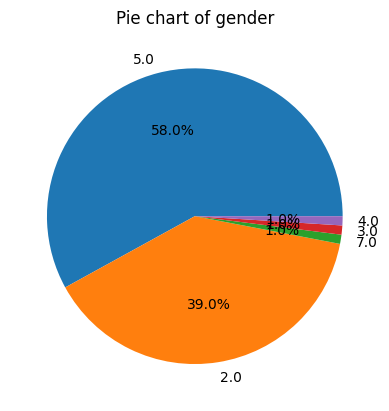

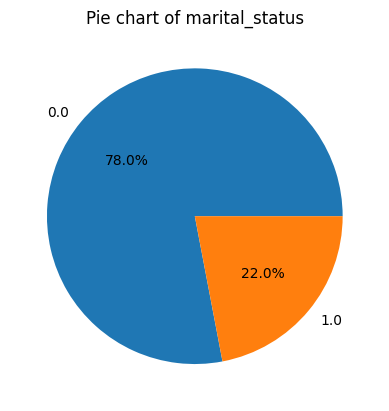

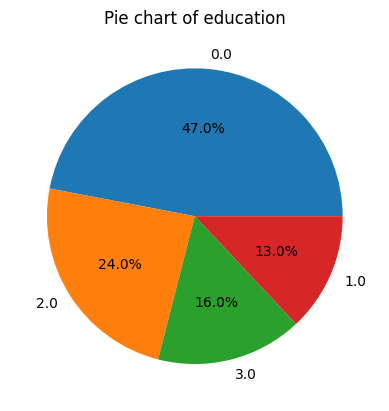

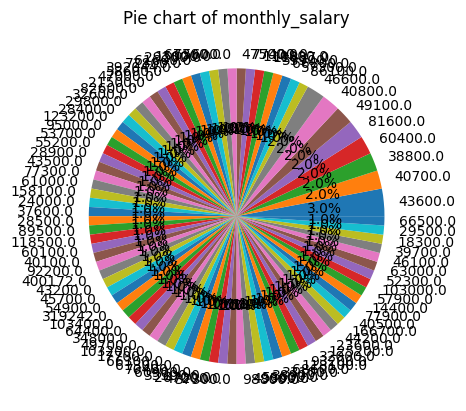

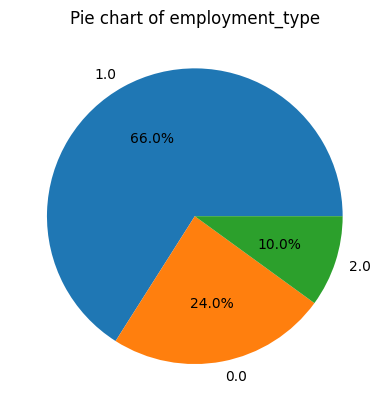

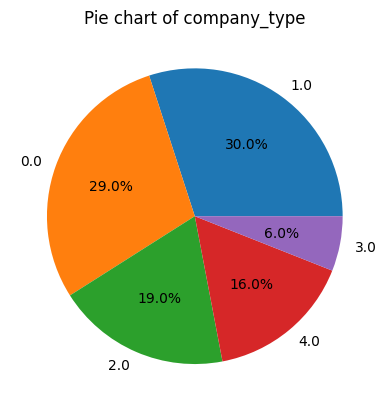

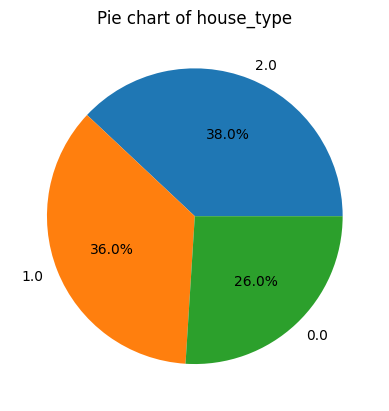

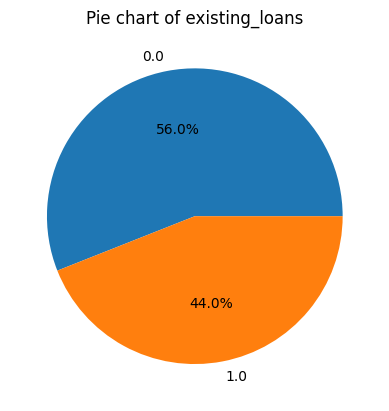

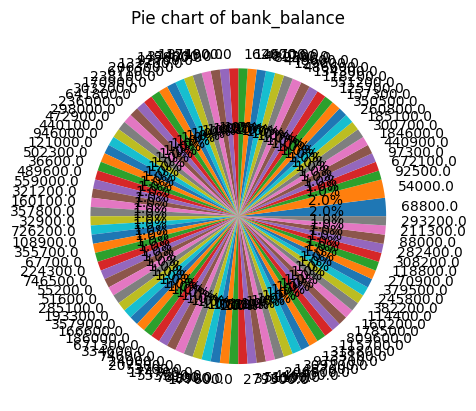

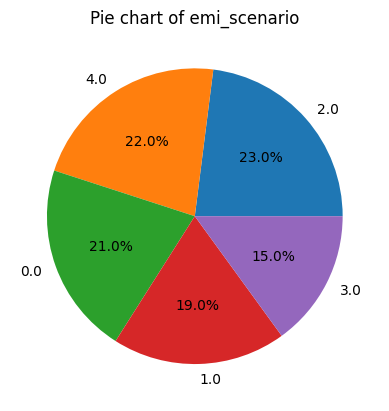

In [38]:
for i in cat:
  x=X_smote[i].head(100).value_counts()
  plt.pie(x,labels=x.index,autopct='%1.1f%%')
  plt.title(f'Pie chart of {i}')
  plt.show()

In [39]:
lr=LogisticRegression(random_state =42)
model=lr.fit(X_smote,Y_smote)

# Drop rows with NaN values from Xtest
Xtest_cleaned = Xtest.dropna()
# Ensure Ytest is aligned with cleaned Xtest
Ytest_cleaned = Ytest.loc[Xtest_cleaned.index]

Ypred_train=model.predict(X_smote)
Ypred_test=model.predict(Xtest_cleaned)

In [40]:
feature_names_classification = normalize_cols(X).columns.tolist()
import joblib
preprocessor = None # Ensure preprocessor is explicitly set to None for this bundle
bundle = {
    "model": model,                       # trained model (classifier or regressor)
    "preprocessor": preprocessor,         # fitted ColumnTransformer / pipeline
    "feature_names": list(Xtrain.columns),   # RAW INPUT column names (important!)

    # Optional but very useful metadata
    "numeric_features": con if 'numeric_features' in globals() else [],
    "categorical_features": cat if 'categorical_features' in globals() else [],
    "target_col": target_col if 'target_col' in globals() else None,
    "mode": "classification"
}

joblib.dump(bundle, "model_bundle.pkl")
print("Saved model_bundle.pkl with keys:", bundle.keys())

Saved model_bundle.pkl with keys: dict_keys(['model', 'preprocessor', 'feature_names', 'numeric_features', 'categorical_features', 'target_col', 'mode'])


In [41]:
import joblib,os # Ensure these are imported globally or within the cell

# Ensure the training bundle & feature names exist; will auto-retrain by executing TRAINING_CODE if missing.
try:
    ensure_classification_bundle(auto_retrain=True, training_code_str=TRAINING_CODE)
except Exception as e:
    raise RuntimeError("Could not ensure classification bundle exists: " + str(e))

# Now load safely
bundle = joblib.load("best_bundle_classification.pkl")
preprocessor = bundle["preprocessor"]
model = bundle["model"]

feature_names = joblib.load("feature_names_classification.pkl")
print("Model and feature names loaded successfully.")

✔ Classification bundle and feature files found.
Model and feature names loaded successfully.


In [42]:
print("Training accuracy score is",accuracy_score(Y_smote,Ypred_train))
print("Testing accuracy score is",accuracy_score(Ytest_cleaned,Ypred_test))
print('***')
print("Training confusion matrix is",confusion_matrix(Y_smote,Ypred_train))
print("Testing confusion matrix is",confusion_matrix(Ytest_cleaned,Ypred_test))

Training accuracy score is 0.9043148546169756
Testing accuracy score is 0.8888482465365095
***
Training confusion matrix is [[241510  29739]
 [ 22170 249079]]
Testing confusion matrix is [[48503  5856]
 [ 1437  9817]]


In [43]:
# 5. Train and Evaluate
dtc=DecisionTreeClassifier(max_depth=3)
rfc=RandomForestClassifier(n_estimators=10)
xgb=XGBClassifier()

In [44]:
dtc=DecisionTreeClassifier(max_depth =3)
model=dtc.fit(X_smote,Y_smote)

# Ensure Ytest is aligned with cleaned Xtest
Ytest_cleaned = Ytest.loc[Xtest_cleaned.index]

Ypred_train=model.predict(X_smote)
Ypred_test=model.predict(Xtest_cleaned)

In [45]:
print("Training accuracy score is",accuracy_score(Y_smote,Ypred_train))
print("Testing accuracy score is",accuracy_score(Ytest_cleaned,Ypred_test))
print('***')
print("Training confusion matrix is",confusion_matrix(Y_smote,Ypred_train))
print("Testing confusion matrix is",confusion_matrix(Ytest_cleaned,Ypred_test))

Training accuracy score is 0.9128273283956807
Testing accuracy score is 0.8704525017908037
***
Training confusion matrix is [[230832  40417]
 [  6874 264375]]
Testing confusion matrix is [[46375  7984]
 [  516 10738]]


In [46]:
rfc=RandomForestClassifier(n_estimators=10)
model=rfc.fit(X_smote,Y_smote)

# Ensure Ytest is aligned with cleaned Xtest
Ytest_cleaned = Ytest.loc[Xtest_cleaned.index]

Ypred_train=model.predict(X_smote)
Ypred_test=model.predict(Xtest_cleaned)

In [47]:
print("Training accuracy score is",accuracy_score(Y_smote,Ypred_train))
print("Testing accuracy score is",accuracy_score(Ytest_cleaned,Ypred_test))
print('***')
print("Training confusion matrix is",confusion_matrix(Y_smote,Ypred_train))
print("Testing confusion matrix is",confusion_matrix(Ytest_cleaned,Ypred_test))

Training accuracy score is 0.9997585244553897
Testing accuracy score is 0.9996647005928703
***
Training confusion matrix is [[271236     13]
 [   118 271131]]
Testing confusion matrix is [[54359     0]
 [   22 11232]]


In [48]:
xgb=XGBClassifier()
best_model=xgb.fit(X_smote,Y_smote)

# Ensure Ytest is aligned with cleaned Xtest
Ytest_cleaned = Ytest.loc[Xtest_cleaned.index]

Ypred_train=model.predict(X_smote)
Ypred_test=model.predict(Xtest_cleaned)

In [49]:
print("Training accuracy score is",accuracy_score(Y_smote,Ypred_train))
print("Testing accuracy score is",accuracy_score(Ytest_cleaned,Ypred_test))
print('***')
print("Training confusion matrix is",confusion_matrix(Y_smote,Ypred_train))
print("Testing confusion matrix is",confusion_matrix(Ytest_cleaned,Ypred_test))

Training accuracy score is 0.9997585244553897
Testing accuracy score is 0.9996647005928703
***
Training confusion matrix is [[271236     13]
 [   118 271131]]
Testing confusion matrix is [[54359     0]
 [   22 11232]]


## **ML** **FLOW**

In [50]:
# Config (edit if desired)
EXPERIMENT_NAME = globals().get("experiment_name", "EMI_Classification")
RUN_NAME = "Classification_Training"
BUNDLE_FILENAMES = [
    "best_bundle_classification.pkl",
    "best_bundle.pkl",
    "best_model_bundle.pkl",
    "best_bundle_classification.save",
    "best_model.pkl",
    "best_bundle_classification.joblib",
    "best_model_bundle.joblib"
]
OUT_DIR = "mlflow_artifacts"
os.makedirs(OUT_DIR, exist_ok=True)

In [51]:
def fetch_or_load(name):
    if name in globals():
        return globals()[name]
    # try to find a bundle file and load it
    for fn in BUNDLE_FILENAMES:
        if os.path.exists(fn):
            b = joblib.load(fn)
            # if bundle is dict-like, try to extract requested object
            if isinstance(b, dict) and name in b:
                return b[name]
            # if user saved model directly in file and requested 'best_model'
            if name == "best_model" and (hasattr(b, "predict") or hasattr(b, "predict_proba")):
                return b
    return None

In [52]:
best_model = fetch_or_load("best_model")
preprocessor = fetch_or_load("preprocessor")
X_test = Xtest_cleaned # Use the cleaned Xtest from previous steps
y_test = Ytest_cleaned # Use the cleaned Ytest from previous steps

In [53]:
# If X_test/y_test not found, try to load them from a bundle
if X_test is None or y_test is None:
    for fn in BUNDLE_FILENAMES:
        if os.path.exists(fn):
            b = joblib.load(fn)
            if isinstance(b, dict):
                X_test = X_test or b.get("X_test") or b.get("X_val") or b.get("X_test_trans") or X_test
                y_test = y_test or b.get("y_test") or b.get("y_val") or y_test

In [54]:
# Final sanity checks
if best_model is None:
    raise RuntimeError("best_model not found in notebook globals or in common bundle files. "
                       "Set variable `best_model` to your fitted XGBClassifier or save & load bundle.")

In [55]:
# Ensure experiment set
mlflow.set_experiment(EXPERIMENT_NAME)

2025/11/28 16:11:13 INFO mlflow.tracking.fluent: Experiment with name 'EMI_Classification' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/534226103498763354', creation_time=1764346273540, experiment_id='534226103498763354', last_update_time=1764346273540, lifecycle_stage='active', name='EMI_Classification', tags={}>

In [56]:
# Prepare transformed test matrix
def safe_transform(preproc, X):
    # if preproc exists and is picklable, use it; otherwise assume model accepts raw X
    if preproc is None:
        return X
    # If X is a pandas Series for single row, convert to DataFrame
    try:
        X_trans = preproc.transform(X)
        return X_trans
    except Exception as e:
        # sometimes preprocessor expects a DataFrame with exact columns — ensure column order
        try:
          if isinstance(X, pd.Series):
                X = X.to_frame().T
          X = X.reindex(columns=preproc.feature_names_in_, fill_value=np.nan)
          return preproc.transform(X)
        except Exception:
            # last resort: try fit/transform? (dangerous) => raise helpful error
            raise RuntimeError(f"preprocessor.transform failed: {e}. Ensure `preprocessor` is the trained ColumnTransformer and X_test is a DataFrame with required columns.")


In [57]:
X_test_trans = safe_transform(preprocessor, X_test) if preprocessor is not None else X_test

In [58]:
# Predictions & basic metrics
y_pred = best_model.predict(X_test_trans)
metrics = {"n_test": int(len(y_test))}

In [59]:
# classification metrics
metrics["accuracy"] = float(accuracy_score(y_test, y_pred))
clf_report = classification_report(y_test, y_pred, output_dict=True)
if "weighted avg" in clf_report:
  metrics["recall_weighted"] = float(clf_report["weighted avg"].get("recall", np.nan))
  metrics["f1_weighted"] = float(clf_report["weighted avg"].get("f1-score", np.nan))

In [60]:
 # Start ML Flow
with mlflow.start_run(run_name=RUN_NAME):
    # basic params
    mlflow.log_param("model_type", type(best_model).__name__)
    # try to log common xgboost params if present
    for p in ("n_estimators", "max_depth", "learning_rate"):
        if hasattr(best_model, p):
            try:
                mlflow.log_param(p, getattr(best_model, p))
            except Exception:
                pass

In [61]:
# log metrics
mlflow.log_metrics(metrics)

In [62]:
# save classification report text
report_txt = classification_report(y_test, y_pred)
rpt_path = os.path.join(OUT_DIR, "classification_report.txt")
with open(rpt_path, "w") as f:
  f.write(report_txt)
mlflow.log_artifact(rpt_path, artifact_path="reports")

In [63]:
# confusion matrix plot (works for binary+multiclass)
try:
    cm = confusion_matrix(y_test, y_pred)
    from sklearn.metrics import ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(6,4))
    disp.plot(ax=ax)
    ax.set_title("Confusion Matrix")
    cm_path = os.path.join(OUT_DIR, "confusion_matrix.png")
    fig.savefig(cm_path, bbox_inches="tight")
    plt.close(fig)
    mlflow.log_artifact(cm_path, artifact_path="confusion_matrices")
except Exception as e:
  print("Warning: could not plot/log confusion matrix:", e)

In [64]:
# Save a joblib bundle (preprocessor + model + metadata) and log as artifact
bundle_name = os.path.join(OUT_DIR, "best_bundle_for_inference.pkl")

try:
  joblib.dump({"preprocessor": preprocessor, "model": best_model, "metrics": metrics}, bundle_name)
  mlflow.log_artifact(bundle_name, artifact_path="bundles")
except Exception as e:
  print("Warning: could not save/log bundle:", e)

In [65]:
# Load saved feature list
feature_names = joblib.load("feature_names_classification.pkl")

# --- Added: Placeholder for new data X_new ---
# In a real scenario, X_new would be loaded from an external source or created.
# For demonstration, we'll use a sample from your existing preprocessed X data.
X_new = X.head(5).copy() # Taking the first 5 rows of your processed X as example new data

# Align inference data
X_new = normalize_cols(X_new)
X_new = X_new.reindex(columns=feature_names, fill_value=0)

In [66]:
feature_names_classification = normalize_cols(X).columns.tolist()
bundle = {
    "model": model,
    "preprocessor": preprocessor,
    # human-friendly metadata:
    "feature_names": list(Xtrain.columns),# raw input column names
    "numeric_features": con,
    "categorical_features": cat,
    "target_col": target_col,
    "mode": "classification"
}
joblib.dump(bundle, "best_bundle_classification.pkl")

['best_bundle_classification.pkl']

In [67]:
# === Modified: align X_new to training columns before transform & predict ===
# Normalize columns same as training
X_new = normalize_cols(X_new)

# Load feature names for the model you intend to use
# For classification bundle:
try:
    feature_names = joblib.load("feature_names_classification.pkl")
except Exception as e:
    # fallback to generic feature_names.pkl if present
    try:
        feature_names = joblib.load("feature_names.pkl")
    except Exception as e2:
        raise RuntimeError("Could not load feature_names_classification.pkl or feature_names.pkl. Save feature names at training time.") from e

# Reindex incoming DataFrame to exact training columns; missing columns filled with 0 (or use a different fill if required)
X_new_aligned = X_new.reindex(columns=feature_names, fill_value=0)

# If preprocessor expects numeric dtypes for certain columns, consider dtype coercion here.
# Now transform and predict, using safe_transform to handle None preprocessor
processed = safe_transform(preprocessor, X_new_aligned)
pred = model.predict(processed)

print('Predictions shape:', len(pred))

Predictions shape: 5


In [68]:
run_id = mlflow.active_run().info.run_id
print("MLflow run complete. run_id:", run_id)
print("Logged metrics:", metrics)
print("Test distribution:", Counter(y_test))
mlflow.end_run() # Added to explicitly end the previous run

MLflow run complete. run_id: 48c5614a52ad494ca6aff769c78815e7
Logged metrics: {'n_test': 65613, 'accuracy': 1.0, 'recall_weighted': 1.0, 'f1_weighted': 1.0}
Test distribution: Counter({'emi_eligibility': 1})


In [69]:
# Save training feature names
feature_names_classification = normalize_cols(X).columns.tolist()
joblib.dump(feature_names_classification, "feature_names_classification.pkl")

['feature_names_classification.pkl']

In [ ]:
from google.colab import files

# Re-create the bundle object for download
bundle = {"preprocessor": preprocessor, "model": best_model, "metrics": metrics}

# Dump the bundle to the specified file
joblib.dump(bundle, "best_bundle_classification.pkl")

# Download the file
files.download("best_bundle_classification.pkl")

##REGRESSION MODEL

In [71]:
# 3. Choose your regression target
reg_target = 'max_monthly_emi'
RANDOM_STATE = 42
EXPERIMENT = "EMI_Regression"
RUN_NAME = "Regression_Training" # Define RUN_NAME for regression
TEST_SIZE = 0.20

In [72]:
# === Added: Save training feature names for regression ===
feature_names_classification_regression = normalize_cols(X).columns.tolist()
joblib.dump(feature_names_classification_regression, "feature_names_regression.pkl")
print("Saved feature_names_regression.pkl")

Saved feature_names_regression.pkl


In [73]:
EXPERIMENT_NAME = globals().get("experiment_name", "EMI_Regression")
RUN_NAME = "Regresion_Training"
BUNDLE_FILENAMES = [
    "best_regressor_bundle.pkl",
    "best_bundle_regression.pkl",
    "best_bundle.pkl",
    "best_model_bundle.pkl",
    "best_model.pkl",
    "best_regressor_bundle.joblib",
    "best_model_bundle.joblib"
]

In [74]:
os.makedirs("artifacts", exist_ok=True)
mlflow.set_experiment(EXPERIMENT)

2025/11/28 16:11:14 INFO mlflow.tracking.fluent: Experiment with name 'EMI_Regression' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/975214226194839964', creation_time=1764346274721, experiment_id='975214226194839964', last_update_time=1764346274721, lifecycle_stage='active', name='EMI_Regression', tags={}>

In [75]:
# 4. Drop any columns you don't want to use as features
drop_cols = [reg_target] # Add any more columns if needed (e.g. IDs, labels)
X = df.drop(drop_cols, axis=1)
y = df[reg_target]

# Ensure age, monthly_salary, bank_balance are numeric and handle any NaNs they might contain
# This is done here to ensure these columns are correctly typed before splitting into cat/con
for col_name in ['age', 'monthly_salary', 'bank_balance']:
    if col_name in X.columns:
        # Convert to numeric, coercing errors to NaN
        X[col_name] = pd.to_numeric(X[col_name], errors='coerce')
        # Fill any NaNs created by coercion or already existing with the mean
        X[col_name] = X[col_name].fillna(X[col_name].mean())

In [76]:
# Separate cat and con from X
cat=[]
con=[]
for i in X.columns:
  if X[i].dtypes=='object':
    cat.append(i)
  else:
    con.append(i)

In [77]:
Xcat=X[cat]
Xcon=X[con]

In [78]:
# Feature Encoding
le=LabelEncoder()
for i in Xcat.columns:
    # Only label encode truly categorical columns, as age, monthly_salary, bank_balance should already be numeric
    # The previous step in cell 9aAN0GbNWSr6 should have handled the numeric conversion and NaN filling for these.
    if i not in ['age', 'monthly_salary', 'bank_balance']:
      Xcat[i]=le.fit_transform(Xcat[i])
Xcat = Xcat.reset_index(drop=True) # Ensure consistent index

In [79]:
# Feature Scaling
ss= StandardScaler()
Xcon=pd.DataFrame(ss.fit_transform(Xcon),columns=con).reset_index(drop=True) # Ensure consistent index

In [80]:
import numpy as np
import pandas as pd

X=Xcon.join(Xcat)
y = y.reset_index(drop=True)

# Comprehensive NaN and Inf handling for all columns in X
for col in X.columns:
    if X[col].dtype == 'object':
        # For object columns, fill with mode (most frequent value)
        X[col] = X[col].fillna(X[col].mode()[0])
    elif pd.api.types.is_numeric_dtype(X[col]):
        # Replace inf/-inf with NaN first, then fill NaNs with mean
        X[col] = X[col].replace([np.inf, -np.inf], np.nan)
        X[col] = X[col].fillna(X[col].mean())

# Final check for any remaining NaNs/Infs in X (should be 0 now)
print("NaNs in X after final fillna:", X.isnull().sum().sum())
print("Infs in X after final fillna:", np.isinf(X).sum().sum())

NaNs in X after final fillna: 0
Infs in X after final fillna: 0


In [81]:
X.shape

(387312, 27)

In [82]:
y.shape

(387312,)

In [83]:
#  Debugging: Check for NaNs and infs before train_test_split
import numpy as np
print("NaNs in X before split:", X.isnull().sum().sum())
print("Infs in X before split:", np.isinf(X).sum().sum())

NaNs in X before split: 0
Infs in X before split: 0


In [84]:
# Perform train test split
from sklearn.model_selection import train_test_split
Xtrain,Xtest,Ytrain,Ytest=train_test_split(X,y,test_size=0.2,random_state=42)

In [85]:
# 7. Define models
models = {
    'Random Forest': RandomForestRegressor(random_state=42,n_estimators =100,n_jobs =-1,max_depth =10),
    'XGBoost': XGBRegressor(random_state=42)
    }

def mse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

results = {}

In [86]:
best_r2_score = -float('inf')
best_reg_model = None

In [87]:
mlflow.end_run() # Ensure any previously active run is ended

In [88]:
for name, model in models.items():
    with mlflow.start_run(run_name=f"{RUN_NAME}_{name}"):
        # Debugging: Check for NaNs and Infs in Xtrain and Ytrain right before fitting
        print(f"--- {name} ---")
        model.fit(Xtrain, Ytrain)
        y_pred = model.predict(Xtest)
        # Calculate metrics
        r2 = r2_score(Ytest, y_pred)
        mse_val = mse(Ytest, y_pred)

--- Random Forest ---
--- XGBoost ---


In [89]:
feature_names_regression = normalize_cols(X).columns.tolist()
if 'preprocessor' not in globals():
    preprocessor = None

# Save everything needed for Streamlit inference
bundle = {
    "model": model,                      # trained model (classifier or regressor)
    "preprocessor": preprocessor,        # fitted ColumnTransformer / pipeline
    "feature_names": list(Xtrain.columns),# RAW INPUT column names (important!)

    # Optional but very useful metadata
    "numeric_features": con, # 'con' list is available and holds numeric feature names
    "categorical_features": cat, # 'cat' list is available and holds categorical feature names
    "target_col": reg_target, # 'reg_target' is defined for regression
    "mode": "regression"
}

joblib.dump(bundle, "best_bundle_regression.pkl")
print("Saved best_bundle_regression.pkl with keys:", bundle.keys())

Saved best_bundle_regression.pkl with keys: dict_keys(['model', 'preprocessor', 'feature_names', 'numeric_features', 'categorical_features', 'target_col', 'mode'])


In [90]:
bundle_reg = joblib.load("best_bundle_regression.pkl")
preprocessor_reg = bundle_reg["preprocessor"]
model_reg = bundle_reg["model"]
feature_names_reg = joblib.load("feature_names_regression.pkl")

In [91]:
# Load training feature names
feature_names = joblib.load("feature_names_regression.pkl")

# Align new data with training feature columns
X_new = normalize_cols(X_new)
X_new = X_new.reindex(columns=feature_names, fill_value=0)

In [92]:
# Log parameters and metrics
mlflow.log_param("model_name", name)
mlflow.log_metrics({"r2_score": r2, "mse": mse_val})

In [93]:
 # Log the model with name and input_example
mlflow.sklearn.log_model(sk_model=model, name="model", input_example=Xtrain)

In [94]:
results[name] = {'R2': r2, 'MSE': mse_val}
print(f"{name} - R2 Score: {r2:.4f}, MSE: {mse_val:.4f}")

XGBoost - R2 Score: 0.9974, MSE: 385.5076


In [95]:
if r2 > best_r2_score:
            best_r2_score = r2
            best_reg_model = model

In [96]:
# Save the best regression model locally
if best_reg_model is not None:
    joblib.dump(best_reg_model, os.path.join(OUT_DIR, "best_regressor_model.pkl"))
    print(f"\nBest regression model ({type(best_reg_model).__name__}) saved with R2 score: {best_r2_score:.4f}")


Best regression model (XGBRegressor) saved with R2 score: 0.9974


In [97]:
# === Added: Save training feature names for regression ===
feature_names_classification = normalize_cols(X).columns.tolist()
joblib.dump(feature_names_classification_regression, "feature_names_regression.pkl")
print("Saved feature_names_regression.pkl")


Saved feature_names_regression.pkl


In [98]:
from google.colab import files

# Re-create the bundle object for download
bundle = {"preprocessor": preprocessor, "model": best_model, "metrics": metrics}

# Dump the bundle to the specified file
joblib.dump(bundle, "best_bundle_regression.pkl")

# Download the file
files.download("best_bundle_regression.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [103]:
import chardet, json

path = "emi_project_cleaned.ipynb"

raw = open(path, "rb").read()
enc = chardet.detect(raw)["encoding"]

print("Detected:", enc)

text = raw.decode(enc, errors="replace")   # decode safely
data = json.loads(text)                    # parse notebook JSON

with open("emi_project_cleaned_UTF8.ipynb", "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False)

print("Saved cleaned UTF-8 notebook as emi_project_cleaned_UTF8.ipynb")

Detected: utf-8
Saved cleaned UTF-8 notebook as emi_project_cleaned_UTF8.ipynb
